In [38]:
import numpy as np
import torch as th
from torch import tensor
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from utils import randexclude
import networkx as nx
from matplotlib import pyplot

# Toy dataset from Decision Transformer (Chen et. al 2021)
class RandomWalks:
    def __init__(self, n_nodes=20, max_length=10, n_walks=1000, p_edge=0.1, seed=1002):
        self.n_nodes = n_nodes
        self.n_walks = n_walks
        self.max_length = max_length
        self.walk_size = max_length
        rng = np.random.RandomState(seed)

        walks, rewards = [], []
        while True:
            self.adj = rng.rand(n_nodes, n_nodes) > (1 - p_edge)
            np.fill_diagonal(self.adj, 0)
            if np.all(self.adj.sum(1)): break

        # terminal state
        self.adj[0, :] = 0
        self.adj[0, 0] = 1

        self.goal = 0
        for _ in range(n_walks):
            node = randexclude(rng, n_nodes, self.goal)
            walk = [node]

            for istep in range(max_length-1):
                node = rng.choice(np.nonzero(self.adj[node])[0])
                walk.append(node)
                if node == self.goal:
                    break

            r = th.zeros(max_length-1)
            r[:len(walk)-1] = -1 if walk[-1] == self.goal else -100

            rewards.append(r)
            walks.append(walk)

        states = []
        attention_masks = []

        for r, walk in zip(rewards, map(th.tensor, walks)):
            attention_mask = th.zeros(max_length, dtype=int)
            attention_mask[:len(walk)] = 1

            attention_masks.append(attention_mask)
            states.append(F.pad(walk, (0, max_length-len(walk))))

        self.worstlen = self.max_length
        self.avglen = sum(map(len, walks)) / self.n_walks
        self.bestlen = 0
        g = nx.from_numpy_array(self.adj, create_using=nx.DiGraph)
        for start in set(range(self.n_nodes)) - {self.goal}:
            try:
                shortest_path = nx.shortest_path(g, start, self.goal)[:self.max_length]
                self.bestlen += len(shortest_path)
            except:
                self.bestlen += self.max_length

        self.bestlen /= self.n_nodes - 1

        print(f'{self.n_walks} walks of which {(np.array([r[0] for r in rewards])==-1).mean()*100:.0f}% arrived at destination')

        # disallows selecting unaccessible nodes in a graph
        self.logit_mask = tensor(~self.adj)

        self.dataset = TensorDataset(th.stack(states), th.stack(attention_masks), th.stack(rewards))
        self.eval_dataset = TensorDataset(th.arange(1, self.n_nodes).unsqueeze(1))

    def render(self):

        g = nx.from_numpy_array(self.adj, create_using=nx.DiGraph)
        pos = nx.spring_layout(g, seed=7357)

        pyplot.figure(figsize=(10, 8))
        nx.draw_networkx_edges(g, pos=pos, alpha=0.5, width=1, edge_color='#d3d3d3')
        nx.draw_networkx_nodes(g, nodelist=set(range(len(self.adj))) - {self.goal}, pos=pos, node_size=300, node_color='orange')
        nx.draw_networkx_nodes(g, nodelist=[self.goal], pos=pos, node_size=300, node_color='darkblue')
        pyplot.show()

    def eval(self, samples, beta):
        narrived = 0
        actlen = 0
        for node in range(self.n_nodes-1):
            for istep in range(self.max_length):
                if samples[node, istep] == self.goal:
                    narrived += 1
                    break

            actlen += (istep + 1) / (self.n_nodes - 1)

        current = (self.worstlen - actlen)/(self.worstlen - self.bestlen)
        average = (self.worstlen - self.avglen)/(self.worstlen - self.bestlen)

        stats = { 'actlen': actlen,
                  'avglen': self.avglen,
                  'bestlen': self.bestlen,
                  'worstlen': self.worstlen,
                  'arrived': f'{narrived / (self.n_nodes-1) * 100:.0f}%',
                  'optimal': f'{current*100:.0f}% > {average*100:.0f}%' }

        return -actlen, stats

1000 walks of which 80% arrived at destination


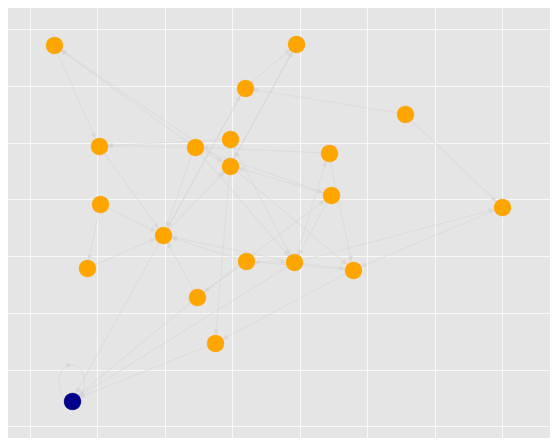

First Walk: tensor([11,  2,  4, 15, 14,  2,  4, 16,  0,  0])
First Walk Reward: tensor([-1., -1., -1., -1., -1., -1., -1., -1.,  0.])


In [39]:
# Create an instance of RandomWalks
n_nodes = 20
max_length = 10
n_walks = 1000
p_edge = 0.1
seed = 1002

random_walks = RandomWalks(n_nodes=n_nodes, max_length=max_length, n_walks=n_walks, p_edge=p_edge, seed=seed)

# Access the dataset containing the walks and rewards
dataset = random_walks.dataset

# Visualize the graph
random_walks.render()

# Example: Access the first walk and its reward
first_walk, _, first_reward = dataset[0]
print("First Walk:", first_walk)
print("First Walk Reward:", first_reward)

In [21]:
import os
import torch as th
import numpy as np
from torch import tensor, nn
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, PretrainedConfig, AutoConfig

from typing import NamedTuple, Tuple, Union
from copy import deepcopy
from collections import defaultdict
from itertools import chain

def topk_mask(xs: th.FloatTensor, k: int):
    mintop = th.topk(xs, k)[0][:, -1].unsqueeze(-1)
    return th.where(xs < mintop, -np.inf * th.ones_like(xs, dtype=xs.dtype), xs)

class QVOutput(Tuple):
    logits: th.FloatTensor
    qs: th.FloatTensor
    target_qs: th.FloatTensor
    vs: th.FloatTensor
    past_key_values: Tuple[th.FloatTensor]

def make_head(n_embd: int, out: int):
    return nn.Sequential(
        nn.Linear(n_embd, n_embd * 2),
        nn.ReLU(),
        nn.Linear(n_embd * 2, out)
    )

class QVModel(nn.Module):
    def __init__(self, config: Union[PretrainedConfig, str], params):
        super().__init__()

        # enable zero3 init within from_pretrained
        if os.environ.get('DEEPSPEED_ZERO_STAGE', '0') == '3':
            config_path = os.environ.get('DEEPSPEED_CONFIG_FILE', '')
            if config_path:
                _hfconfig = transformers.deepspeed.HfDeepSpeedConfig(config_path)

        if isinstance(config, PretrainedConfig):
            self.gpt = AutoModelForCausalLM.from_config(config)
        else:
            self.gpt = AutoModelForCausalLM.from_pretrained(config)

        if hasattr(self.gpt.config, 'hidden_size'):
            self.n_embd = self.gpt.config.hidden_size
        else:
            self.n_embd = self.gpt.config.n_embd
        self.vocab_size = self.gpt.config.vocab_size

        self.v_head = make_head(self.n_embd, 1)
        self.q1_head = make_head(self.n_embd, self.vocab_size)
        self.target_q1_head = deepcopy(self.q1_head)
        self.target_q1_head.requires_grad_(False)

        self.tau = params['tau']
        self.alpha = params['alpha']
        self.gamma = params['gamma']
        self.awac_scale = params['awac_scale']
        self.cql_scale = params['cql_scale']
        self.two_qs = params['two_qs']

        if self.two_qs:
            self.q2_head = make_head(self.n_embd, self.vocab_size)
            self.target_q2_head = deepcopy(self.q2_head)
            self.target_q2_head.requires_grad_(False)

    def forward(self, **x):
        if hasattr(self.gpt, 'gpt_neox'):
            out = self.gpt.gpt_neox(**x)
        else:
            out = self.gpt.transformer(**x)

        hs = out.last_hidden_state

        if self.two_qs:
            qs = (self.q1_head(hs), self.q2_head(hs))
            target_qs = (self.target_q1_head(hs), self.target_q2_head(hs))
        else:
            qs = self.q1_head(hs)
            target_qs = self.target_q1_head(hs)

        if hasattr(self.gpt, 'gpt_neox'):
            logits = self.gpt.embed_out(hs)
        else:
            logits = self.gpt.lm_head(hs)

        return QVOutput((logits, qs, target_qs, self.v_head(hs), out.past_key_values))

    def loss(self, batch):
        tokens, attn, rewards = batch
        actions = tokens[:, 1:, None]
        isterminal = attn[:, :-1]

        logits, qs, target_qs, vs, _ = self(input_ids=tokens, attention_mask=attn)
        bsize, ntokens, dsize = logits.shape

        if self.two_qs:
            Q1 = qs[0][:, :-1].gather(-1, actions).squeeze(-1)
            Q2 = qs[1][:, :-1].gather(-1, actions).squeeze(-1)

            targetQ1 = target_qs[0][:, :-1].gather(-1, actions).squeeze(-1).detach()
            targetQ2 = target_qs[1][:, :-1].gather(-1, actions).squeeze(-1).detach()
            targetQ = th.minimum(targetQ1, targetQ2)
        else:
            Q = qs[:, :-1].gather(-1, actions).squeeze(-1)
            targetQ = target_qs[:, :-1].gather(-1, actions).squeeze(-1).detach()

        n_nonterminal = max(1, isterminal.sum())
        V = vs[:, 1:].squeeze() * isterminal
        Q_ = rewards + self.gamma * V

        if self.two_qs:
            loss_q1 = ((Q1 - Q_.detach()) * isterminal).pow(2).sum() / n_nonterminal
            loss_q2 = ((Q2 - Q_.detach()) * isterminal).pow(2).sum() / n_nonterminal
            loss_q = loss_q1 + loss_q2
        else:
            loss_q = ((Q - Q_.detach()) * isterminal).pow(2).sum() / n_nonterminal

        loss_v = (((targetQ >= V).int() * self.tau * (targetQ - V).pow(2) + (targetQ < V).int() * (1 - self.tau) * (targetQ - V).pow(2)) * isterminal).sum() / n_nonterminal

        if self.two_qs:
            loss_cql_q1 = (F.cross_entropy(qs[0][:, :-1].reshape(-1, dsize), actions.reshape(-1), reduction='none').reshape(bsize, ntokens-1) * isterminal).sum() / n_nonterminal
            loss_cql_q2 = (F.cross_entropy(qs[1][:, :-1].reshape(-1, dsize), actions.reshape(-1), reduction='none').reshape(bsize, ntokens-1) * isterminal).sum() / n_nonterminal
            loss_cql = loss_cql_q1 + loss_cql_q2
        else:
            loss_cql = (F.cross_entropy(qs[:, :-1].reshape(-1, dsize), actions.reshape(-1), reduction='none').reshape(bsize, ntokens-1) * isterminal).sum() / n_nonterminal

        loss_awac = (F.cross_entropy(logits[:, :-1].reshape(-1, dsize), actions.reshape(-1), reduction='none').reshape(bsize, ntokens-1) * isterminal).sum() / n_nonterminal

        loss = loss_q + loss_v + self.cql_scale * loss_cql + self.awac_scale * loss_awac
        stats = {
            k: v for k, v in locals().items() if k in
            ['loss', 'loss_v', 'loss_q', 'loss_cql', 'loss_awac']
        }

        return loss, stats

    def _sync_target_q_heads(self, alpha):
        for target_param, copy_param in zip(self.target_q1_head.parameters(), self.q1_head.parameters()):
            target_param.data.copy_((alpha * copy_param.data) + (1.0 - alpha) * target_param.data)

        if self.two_qs:
            for target_param, copy_param in zip(self.target_q2_head.parameters(), self.q2_head.parameters()):
                target_param.data.copy_((alpha * copy_param.data) + (1.0 - alpha) * target_param.data)

    @th.inference_mode()
    def sample(self, query, beta=1, max_length=32, temperature=1, top_k=20, logit_mask=None, logs=True, eos_token_id=50256):
        input = query.clone()
        past_key_values = None
        tensors = defaultdict(list)

        finished = th.zeros(input.shape[0], 1, dtype=th.long, device=query.device)

        for _ in range(max_length-1):
            logits, _, target_qs, vs, past_key_values = self.forward(input_ids=input, past_key_values=past_key_values)

            if self.two_qs:
                qs = th.minimum(target_qs[0][:, -1], target_qs[1][:, -1])
            else:
                qs = target_qs[:, -1]

            logits = logits[:, -1]

            if logit_mask is not None:
                logits[th.where(logit_mask[input[:, -1]])] = -np.inf

            adv = qs - vs[:, -1, :]
            pi = F.log_softmax(logits, -1)
            modpi = topk_mask(pi + beta * adv, top_k)
            ps = F.softmax(modpi / temperature, -1)

            tokens = th.multinomial(ps, 1)
            tokens = (1 - finished) * tokens + finished * eos_token_id

            query = th.hstack((query, tokens))

            input = tokens
            finished = (tokens == eos_token_id).long()

            if logs:
                tensors['qs'].append(qs)
                tensors['vs'].append(vs)
                tensors['adv'].append(adv)

        stats = {}
        for name, xs in tensors.items():
            xs = th.vstack(xs)
            stats.update({
                f'{name}-min': xs.min(),
                f'{name}-max': xs.max(),
                f'{name}-std': xs.std(),
                f'{name}-avg': xs.mean(),
            })

        return query, stats

    @property
    def dummy_inputs(self):
        return {'input_ids': th.ones(1, 1, device=self.gpt.device, dtype=th.long)}

    @property
    def device(self):
        return self.gpt.device

In [16]:
import os
import sys
import yaml
import torch as th
from torch.utils.data import DataLoader
from transformers import GPT2Config
from tqdm import tqdm, trange
import numpy as np

th.set_printoptions(sci_mode=False)

def main(**args):
    task = 'RandomWalks'
    config = yaml.safe_load(open('config.yaml'))[task]
    config.update(args)

    device = th.device("cuda" if th.cuda.is_available() else "cpu")
    th.manual_seed(config['seed'])

    data = RandomWalks(seed=config['seed'])
    gptconfig = GPT2Config(**config['gptconfig'], vocab_size=data.n_nodes)
    model = QVModel(gptconfig, config).to(device)

    for m in model.gpt.transformer.h[:-config['n_layers_unfrozen']]:
        m.requires_grad_(False)

    train_dataloader = DataLoader(data.dataset, batch_size=config['batch_size'])
    opt = th.optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=config['lr'], betas=config['opt_betas'])

    total_steps = int(config['n_epochs'] * (len(data.dataset) // config['batch_size']))
    model.train()

    for _ in trange(total_steps):
        for batch in train_dataloader:
            batch = [item.to(device) for item in batch]
            loss, stats = model.loss(batch)

            opt.zero_grad()
            loss.backward()
            opt.step()

            # if stats:
            #     print(stats)  # Optionally, print stats for each batch

    return model, data

In [17]:
args = {'debug': True}
main(**args)

1000 walks of which 18% arrived at destination


100%|██████████| 200/200 [01:53<00:00,  1.76it/s]


(QVModel(
   (gpt): GPT2LMHeadModel(
     (transformer): GPT2Model(
       (wte): Embedding(20, 144)
       (wpe): Embedding(1024, 144)
       (drop): Dropout(p=0.1, inplace=False)
       (h): ModuleList(
         (0-5): 6 x GPT2Block(
           (ln_1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
           (attn): GPT2Attention(
             (c_attn): Conv1D()
             (c_proj): Conv1D()
             (attn_dropout): Dropout(p=0.1, inplace=False)
             (resid_dropout): Dropout(p=0.1, inplace=False)
           )
           (ln_2): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
           (mlp): GPT2MLP(
             (c_fc): Conv1D()
             (c_proj): Conv1D()
             (act): NewGELUActivation()
             (dropout): Dropout(p=0.1, inplace=False)
           )
         )
       )
       (ln_f): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
     )
     (lm_head): Linear(in_features=144, out_features=20, bias=False)
   )
   (v_head): Sequentia

1000 walks of which 37% arrived at destination


100%|██████████| 200/200 [01:49<00:00,  1.82it/s]
/var/folders/wg/cdt_cw_5265_z_gwnxlf0tv80000gn/T/ipykernel_17189/4108513398.py:36: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  length = np.where(path.numpy() == data.goal)[0][0] if data.goal in path.numpy() else data.max_length


1000 walks of which 74% arrived at destination


100%|██████████| 200/200 [01:58<00:00,  1.69it/s]


1000 walks of which 29% arrived at destination


100%|██████████| 200/200 [01:56<00:00,  1.72it/s]


1000 walks of which 51% arrived at destination


100%|██████████| 200/200 [01:51<00:00,  1.80it/s]


1000 walks of which 7% arrived at destination


100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


1000 walks of which 69% arrived at destination


100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


1000 walks of which 92% arrived at destination


100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


1000 walks of which 50% arrived at destination


100%|██████████| 200/200 [01:49<00:00,  1.83it/s]


1000 walks of which 15% arrived at destination


100%|██████████| 200/200 [01:48<00:00,  1.85it/s]


1000 walks of which 32% arrived at destination


100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


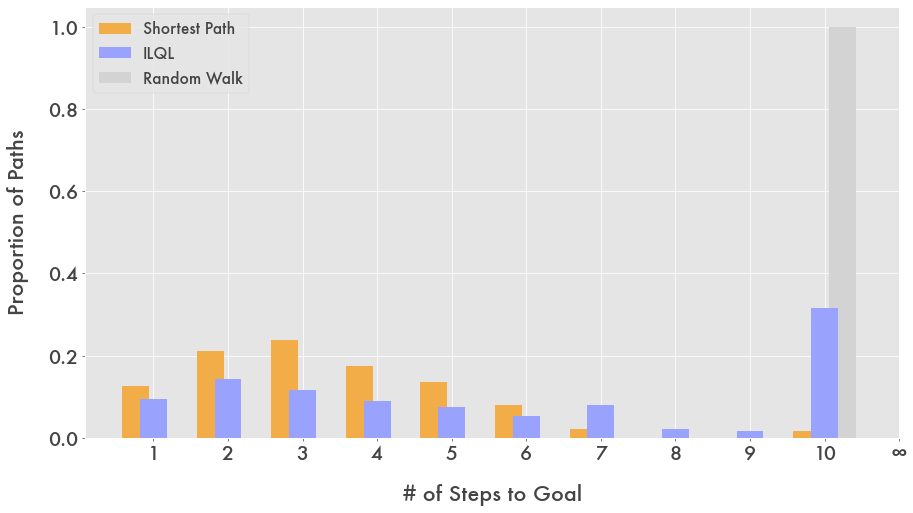

In [29]:
import torch as th
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

# Assuming model, data, and main function are defined as before
optimal_lengths = []
sampled_lengths = []
iql_lengths = []

for seed in range(10):
    model, data = main(seed=seed, debug=True)
    model.eval()

    g = nx.from_numpy_array(data.adj, create_using=nx.DiGraph)

    # Optimal paths calculation
    for start in range(data.n_nodes):
        if start != data.goal:
            try:
                shortest_path = nx.shortest_path(g, start, data.goal)
                optimal_lengths.append(len(shortest_path) - 1)
            except nx.NetworkXNoPath:
                optimal_lengths.append(data.max_length)

    # ILQL (model-generated) paths calculation
    starts = th.arange(data.n_nodes).unsqueeze(1).to(model.device)
    paths, _ = model.sample(starts, max_length=data.max_length, logit_mask=tensor(~data.adj), beta=10)
    for path in paths.cpu().numpy():
        iql_lengths.append(np.where(path == data.goal)[0][0] if data.goal in path else data.max_length)

    # Random walk paths calculation
    for batch in data.dataset:
        for path in batch[0]:
            length = np.where(path.numpy() == data.goal)[0][0] if data.goal in path.numpy() else data.max_length
            sampled_lengths.append(length)

fontcolor = '#444'
# Bar sizes and colors for the plot
barsize = 0.36
iql_color = '#99a3fd'
opt_color = '#f2ad48'
random_color = 'lightgray'

matplotlib.rcParams['text.color'] = fontcolor
matplotlib.rcParams['axes.labelcolor'] = fontcolor
matplotlib.rcParams['xtick.color'] = fontcolor
matplotlib.rcParams['ytick.color'] = fontcolor
matplotlib.rcParams['xtick.labelcolor'] = fontcolor
matplotlib.rcParams['ytick.labelcolor'] = fontcolor
matplotlib.rcParams['xtick.labelcolor'] = fontcolor

matplotlib.rcParams["font.family"] = "Futura"
matplotlib.rcParams["font.size"] = 15
matplotlib.rcParams["xtick.labelsize"] = 20
matplotlib.rcParams["ytick.labelsize"] = 20
matplotlib.rcParams["figure.titlesize"] = 12
matplotlib.rcParams["figure.figsize"] = 15, 8

matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.dpi'] = 70

plt.figure(figsize=(15, 8))

# Adjusted bin range to include all lengths from 1 to max_length, plus one additional bin
bins = np.arange(1, data.max_length + 2)

# Histogram calculation
optimal_hist = np.histogram(optimal_lengths, bins=bins, density=True)[0]
sampled_hist = np.histogram(sampled_lengths, bins=bins, density=True)[0]
iql_hist = np.histogram(iql_lengths, bins=bins, density=True)[0]

# Adjust x-ticks to properly align with the bars
x_ticks = np.arange(1, data.max_length + 1)

# Plotting histograms
plt.bar(x_ticks - barsize/1.5, optimal_hist, width=barsize, label='Shortest Path', color=opt_color, zorder=2)
plt.bar(x_ticks, iql_hist, width=barsize, label='ILQL', color=iql_color, zorder=3)
plt.bar(x_ticks + barsize/1.5, sampled_hist, width=barsize, label='Random Walk', color=random_color, zorder=1)

# Adjusting x-axis labels to properly reflect the bins
plt.xticks(np.arange(1, data.max_length + 2), list(np.arange(1, data.max_length + 1)) + ['∞'])

plt.legend(fontsize=16)
plt.xticks(np.arange(1, data.max_length+2), list(np.arange(1, data.max_length+1)) + ['∞'])
plt.xlabel('# of Steps to Goal', fontsize=22, color=fontcolor, labelpad=20)
plt.ylabel('Proportion of Paths', fontsize=22, color=fontcolor, labelpad=20)

plt.savefig('graph_plot.svg')
plt.show()

## Please let this work

In [100]:
import torch
import torch.nn as nn
from torchtyping import TensorType
from einops import rearrange
from transformer_lens import HookedTransformer, HookedTransformerConfig

class RandomWalksTransformerConfig:
    def __init__(self):
        self.n_nodes = 20  # Number of nodes in the graph
        self.d_model = 128  # Dimension of the embeddings
        self.n_heads = 4    # Number of attention heads
        self.n_layers = 4   # Number of transformer layers
        self.max_length = 10  # Maximum length of a sequence
        self.n_ctx = self.max_length * 3  # Context size
        self.d_head = int(self.d_model / self.n_heads)  # Dimension per head
        self.act_fn = "relu"  # Activation function

class DecisionTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embeddings
        self.node_embedding = nn.Embedding(config.n_nodes, config.d_model)
        self.position_embedding = nn.Embedding(config.max_length, config.d_model)
        self.action_embedding = nn.Embedding(config.n_nodes + 1, config.d_model)
        self.reward_embedding = nn.Linear(1, config.d_model)

        # Transformer
        transformer_cfg = HookedTransformerConfig(
            n_layers=config.n_layers,
            d_model=config.d_model,
            d_head=config.d_head,
            n_heads=config.n_heads,
            d_vocab=config.n_nodes + 1,
            d_mlp=config.d_model * 4,
            normalization_type='LayerNorm',
            d_vocab_out=config.d_model,
            attention_dir='causal',
            n_ctx=config.n_ctx,
            act_fn=config.act_fn,
        )
        self.transformer = HookedTransformer(transformer_cfg)

        # Output head for action prediction
        self.action_head = nn.Linear(config.d_model, config.n_nodes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, states, actions, rewards, timesteps):
        batch_size, seq_length = states.shape

        # Embeddings
        state_embeddings = self.node_embedding(states)
        position_embeddings = self.position_embedding(timesteps)
        action_embeddings = self.action_embedding(actions)
        reward_embeddings = self.reward_embedding(rewards.unsqueeze(-1))

        # Combine embeddings
        embeddings = state_embeddings + position_embeddings + action_embeddings + reward_embeddings
        embeddings = rearrange(embeddings, "b s d -> s b d")

        # Transformer
        transformer_output = self.transformer(embeddings)

        # Action prediction
        action_logits = self.action_head(transformer_output)
        return action_logits

    def predict_next_action(self, states, actions, rewards, timesteps):
        logits = self.forward(states, actions, rewards, timesteps)
        return torch.argmax(logits, dim=-1)

# Example usage
config = RandomWalksTransformerConfig()
model = DecisionTransformer(config)

# Example data (batch_size, sequence_length)
states = torch.randint(0, config.n_nodes, (1, config.max_length))
actions = torch.randint(0, config.n_nodes, (1, config.max_length))
rewards = torch.randn(1, config.max_length)
timesteps = torch.arange(config.max_length).unsqueeze(0)

# Forward pass
logits = model(states, actions, rewards, timesteps)
next_action = model.predict_next_act

IndexError: tensors used as indices must be long, int, byte or bool tensors

## Rewriting with decision transformer

In [60]:
import torch
import torch.nn as nn
import numpy as np
from torch.nn import functional as F
from einops import rearrange

class RandomWalksTransformerConfig:
    """Configuration for the RandomWalks Transformer"""
    def __init__(self):
        self.n_nodes = 20  # Number of nodes in the graph
        self.d_model = 128  # Dimension of the embeddings
        self.n_heads = 4    # Number of attention heads
        self.n_layers = 4   # Number of transformer layers
        self.max_length = 10  # Maximum length of a sequence

class DecisionTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding layers
        self.node_embedding = nn.Embedding(config.n_nodes, config.d_model)
        self.position_embedding = nn.Embedding(config.max_length, config.d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=config.d_model, nhead=config.n_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=config.n_layers)

        # Output heads
        self.action_head = nn.Linear(config.d_model, config.n_nodes)  # Predicting the next node
        self.value_head = nn.Linear(config.d_model, 1)  # Estimating the value

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, tokens, attn):
        """
        tokens: Tensor of shape (batch_size, sequence_length)
        attn: Tensor of shape (batch_size, sequence_length) indicating valid positions
        """
        # Embeddings
        node_embeddings = self.node_embedding(tokens)  # (batch_size, sequence_length, d_model)

        # Derive positions from attention masks
        positions = attn.cumsum(dim=1) - 1  # Calculate positions based on attn
        position_embeddings = self.position_embedding(positions)  # (batch_size, sequence_length, d_model)

        # Combine embeddings
        x = node_embeddings + position_embeddings  # (batch_size, sequence_length, d_model)

        # Transformer
        x = rearrange(x, "b s d -> s b d")  # Transformer expects (sequence_length, batch_size, d_model)
        x = self.transformer_encoder(x)

        # Output heads
        action_logits = self.action_head(x)
        values = self.value_head(x).squeeze(-1)

        return F.log_softmax(action_logits, dim=-1), values

    def predict_next_node(self, tokens, attn):
        logits, _ = self.forward(tokens, attn)
        return torch.argmax(logits, dim=-1)

# Example usage
config = RandomWalksTransformerConfig()
model = DecisionTransformer(config)

# Example data
tokens = torch.randint(0, config.n_nodes, (1, config.max_length))  # Random sequence of nodes

# Simulating attention masks (1s for valid positions, 0s for padding)
attn = torch.ones_like(tokens)  # Assuming all positions are valid for this example

# Forward pass
logits, values = model(tokens, attn)
next_node = model.predict_next_node(tokens, attn)

# Print results
print("Logits:", logits.shape)
print("Values:", values.shape)
print("Predicted next node:", next_node)

Logits: torch.Size([10, 1, 20])
Values: torch.Size([10, 1])
Predicted next node: tensor([[ 5],
        [ 0],
        [11],
        [12],
        [14],
        [19],
        [10],
        [15],
        [10],
        [11]])


/Users/charlesoneill/miniconda3/envs/honours/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [74]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from torch.nn.functional import cross_entropy
from tqdm import tqdm
import yaml

def main(**args):
    # Load and update configuration
    config = yaml.safe_load(open('config.yaml'))['RandomWalks']
    config.update(args)

    # Initialize device, data, and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data = RandomWalks(seed=config['seed'])  # Assuming RandomWalks dataset is defined
    model_config = RandomWalksTransformerConfig()
    model = DecisionTransformer(model_config).to(device)

    # DataLoader and optimizer
    train_dataloader = DataLoader(data.dataset, batch_size=config['batch_size'])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

    # Training loop
    for i in tqdm(range(config['n_epochs']), desc="Training"):
        for batch in train_dataloader:
            tokens, attn, rewards = batch
            tokens = tokens.to(device)

            # Forward pass
            logits, _ = model(tokens[:, :-1], attn[:, :-1])  # Use tokens and attn excluding the last element

            # Prepare actions
            actions = tokens[:, 1:].contiguous().to(device)  # Shift tokens by one for next node prediction
            loss = compute_loss(logits, actions)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Print every 10 epochs
        # if i % 10 == 0:
        #     print(f"Epoch {i}, Loss: {loss.item()}")

    return model, data

def compute_loss(logits, actions):
    # Print shapes
    # print("Logits:", logits.shape)
    # print("Actions:", actions.shape)
    
    logits = logits.reshape(-1, logits.size(-1))  # Reshape to [batch_size * sequence_length, n_nodes]
    actions = actions.view(-1)  # Flatten actions
    return cross_entropy(logits, actions)

# Assuming RandomWalks, RandomWalksTransformerConfig, and DecisionTransformer are defined

In [70]:
model, data = main()

/Users/charlesoneill/miniconda3/envs/honours/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


1000 walks of which 18% arrived at destination


Training:   1%|          | 1/100 [00:00<01:11,  1.39it/s]

Epoch 0, Loss: 3.413510799407959


Training:  11%|█         | 11/100 [00:07<01:03,  1.40it/s]

Epoch 10, Loss: 2.67281174659729


Training:  21%|██        | 21/100 [00:15<00:57,  1.39it/s]

Epoch 20, Loss: 2.6557464599609375


Training:  31%|███       | 31/100 [00:22<00:50,  1.36it/s]

Epoch 30, Loss: 2.6622045040130615


Training:  41%|████      | 41/100 [00:29<00:43,  1.37it/s]

Epoch 40, Loss: 2.6485483646392822


Training:  51%|█████     | 51/100 [00:37<00:35,  1.40it/s]

Epoch 50, Loss: 2.63748836517334


Training:  61%|██████    | 61/100 [00:44<00:28,  1.39it/s]

Epoch 60, Loss: 2.6365609169006348


Training:  71%|███████   | 71/100 [00:51<00:21,  1.37it/s]

Epoch 70, Loss: 2.6291348934173584


Training:  81%|████████  | 81/100 [00:58<00:13,  1.38it/s]

Epoch 80, Loss: 2.631920337677002


Training:  91%|█████████ | 91/100 [01:06<00:06,  1.37it/s]

Epoch 90, Loss: 2.6239607334136963


Training: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


In [77]:
import torch as th
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

def sample_paths(model, data):
    device = next(model.parameters()).device
    sampled_paths = []

    for start_node in range(data.n_nodes):
        path = [start_node]
        for step in range(1, data.max_length):
            current_nodes = torch.tensor([path], dtype=torch.long, device=device)
            current_positions = torch.arange(start=step, end=step + len(path), dtype=torch.long, device=device).unsqueeze(0)
            
            # Ensure positions are within the valid range
            current_positions = torch.clamp(current_positions, max=data.max_length - 1)

            next_node = model.predict_next_node(current_nodes, current_positions)[0, -1].item()
            if next_node == data.goal:
                path.append(next_node)
                break
            elif len(path) < data.max_length:
                path.append(next_node)

        sampled_paths.append(path)
    return sampled_paths

# Assuming model, data, and main function are defined as before
optimal_lengths = []
sampled_lengths = []
iql_lengths = []

for seed in range(2):
    model, data = main(seed=seed, debug=True)
    model.eval()

    g = nx.from_numpy_array(data.adj, create_using=nx.DiGraph)

    # Optimal paths calculation
    for start in range(data.n_nodes):
        if start != data.goal:
            try:
                shortest_path = nx.shortest_path(g, start, data.goal)
                optimal_lengths.append(len(shortest_path) - 1)
            except nx.NetworkXNoPath:
                optimal_lengths.append(data.max_length)

    # ILQL (model-generated) paths calculation
    model_generated_paths = sample_paths(model, data)
    for path in model_generated_paths:
        iql_lengths.append(len(path) - 1 if path[-1] == data.goal else data.max_length)

    # Random walk paths calculation
    for batch in data.dataset:
        for path in batch[0]:
            length = np.where(path.numpy() == data.goal)[0][0] if data.goal in path.numpy() else data.max_length
            sampled_lengths.append(length)

fontcolor = '#444'
# Bar sizes and colors for the plot
barsize = 0.36
iql_color = '#99a3fd'
opt_color = '#f2ad48'
random_color = 'lightgray'

matplotlib.rcParams['text.color'] = fontcolor
matplotlib.rcParams['axes.labelcolor'] = fontcolor
matplotlib.rcParams['xtick.color'] = fontcolor
matplotlib.rcParams['ytick.color'] = fontcolor
matplotlib.rcParams['xtick.labelcolor'] = fontcolor
matplotlib.rcParams['ytick.labelcolor'] = fontcolor
matplotlib.rcParams['xtick.labelcolor'] = fontcolor

matplotlib.rcParams["font.family"] = "Futura"
matplotlib.rcParams["font.size"] = 15
matplotlib.rcParams["xtick.labelsize"] = 20
matplotlib.rcParams["ytick.labelsize"] = 20
matplotlib.rcParams["figure.titlesize"] = 12
matplotlib.rcParams["figure.figsize"] = 15, 8

matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.dpi'] = 70

plt.figure(figsize=(15, 8))

# Adjusted bin range to include all lengths from 1 to max_length, plus one additional bin
bins = np.arange(1, data.max_length + 2)

# Histogram calculation
optimal_hist = np.histogram(optimal_lengths, bins=bins, density=True)[0]
sampled_hist = np.histogram(sampled_lengths, bins=bins, density=True)[0]
iql_hist = np.histogram(iql_lengths, bins=bins, density=True)[0]

# Adjust x-ticks to properly align with the bars
x_ticks = np.arange(1, data.max_length + 1)

# Plotting histograms
plt.bar(x_ticks - barsize/1.5, optimal_hist, width=barsize, label='Shortest Path', color=opt_color, zorder=2)
plt.bar(x_ticks, iql_hist, width=barsize, label='ILQL', color=iql_color, zorder=3)
plt.bar(x_ticks + barsize/1.5, sampled_hist, width=barsize, label='Random Walk', color=random_color, zorder=1)

# Adjusting x-axis labels to properly reflect the bins
plt.xticks(np.arange(1, data.max_length + 2), list(np.arange(1, data.max_length + 1)) + ['∞'])

plt.legend(fontsize=16)
plt.xticks(np.arange(1, data.max_length+2), list(np.arange(1, data.max_length+1)) + ['∞'])
plt.xlabel('# of Steps to Goal', fontsize=22, color=fontcolor, labelpad=20)
plt.ylabel('Proportion of Paths', fontsize=22, color=fontcolor, labelpad=20)

plt.savefig('graph_plot.svg')
plt.show()

1000 walks of which 37% arrived at destination


Training: 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]


IndexError: index out of range in self

## Another go

In [81]:
import torch
import torch.nn as nn
from transformer_lens import HookedTransformer, HookedTransformerConfig
from einops import rearrange
from dataclasses import dataclass

@dataclass
class TransformerConfig:
    d_model: int = 128
    n_heads: int = 4
    d_mlp: int = 256
    n_layers: int = 2
    n_ctx: int = 2
    layer_norm: Optional[str] = None
    gated_mlp: bool = False
    activation_fn: str = "relu"
    state_embedding_type: str = "grid"
    time_embedding_type: str = "embedding"
    seed: int = 1
    device: str = "cpu"

class DecisionTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.transformer_config = config

        # Embeddings
        self.node_embedding = nn.Embedding(config.n_nodes, config.d_model)
        self.time_embedding = nn.Embedding(config.max_length, config.d_model)
        self.reward_embedding = nn.Linear(1, config.d_model)

        # Transformer
        transformer_cfg = HookedTransformerConfig(
            n_layers=config.n_layers,
            d_model=config.d_model,
            d_head=config.d_model // config.n_heads,  # Adjust d_head accordingly
            n_heads=config.n_heads,
            d_mlp=config.d_model * 4,
            normalization_type='LayerNorm',
            d_vocab_out=config.d_model,
            attention_dir='causal',
            n_ctx=config.max_length

        )
        self.transformer = HookedTransformer(transformer_cfg)

        # Output head for action prediction
        self.action_head = nn.Linear(config.d_model, config.n_nodes)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize weights as needed
        pass

    def forward(self, nodes, times, rewards, actions=None):
        # Embeddings
        node_embeddings = self.node_embedding(nodes)  # [batch_size, seq_length, d_model]
        time_embeddings = self.time_embedding(times)  # [batch_size, seq_length, d_model]
        reward_embeddings = self.reward_embedding(rewards.unsqueeze(-1))  # [batch_size, seq_length, d_model]

        # Combine embeddings
        embeddings = node_embeddings + time_embeddings + reward_embeddings

        # Transformer
        x = rearrange(embeddings, "b s d -> s b d")
        transformer_output = self.transformer(x)
        transformer_output = rearrange(transformer_output, "s b d -> b s d")

        # Action prediction
        action_logits = self.action_head(transformer_output)

        return torch.log_softmax(action_logits, dim=-1)

    # Additional methods for sampling, reward prediction, etc.

# Configuration and model initialization
config = RandomWalksTransformerConfig()
model = DecisionTransformer(config)

# Example data
batch_size = 5
seq_length = config.max_length
nodes = torch.randint(0, config.n_nodes, (batch_size, seq_length))  # Random sequence of nodes
times = torch.arange(seq_length).expand(batch_size, seq_length)  # Position sequence
rewards = torch.randn(batch_size, seq_length)  # Example rewards

# Forward pass
logits = model(nodes, times, rewards)
predicted_actions = torch.argmax(logits, dim=-1)

AssertionError: act_fn must be specified for non-attn-only models

In [ ]:
class DecisionTransformer:

    def __init__(self, transformer_config):
        self.transformer_config = transformer_config

        # Why is this in a sequential? 
        self.action_embedding = nn.Sequential(
            nn.Embedding(
                environment_config.action_space.n + 1,
                self.transformer_config.d_model,
            )
        )
        self.time_embedding = self.initialize_time_embedding()
        self.state_embedding = self.initialize_state_embedding()

        # Initialise weights
        nn.init.normal_(
            self.action_embedding[0].weight,
            mean=0.0,
            std=1
            / (
                (environment_config.action_space.n + 1 + 1)
                * self.transformer_config.d_model
            ),
        )

        self.transformer = self.initialize_easy_transformer()

        self.action_predictor = nn.Linear(
            self.transformer_config.d_model, environment_config.action_space.n
        )
        self.initialize_state_predictor()

        self.initialize_weights()

        self.reward_embedding = nn.Sequential(
            nn.Linear(1, self.transformer_config.d_model, bias=False)
        )
        self.reward_predictor = nn.Linear(self.transformer_config.d_model, 1)

        # n_ctx include full timesteps except for the last where it doesn't know the action
        assert (transformer_config.n_ctx - 2) % 3 == 0

        self.initialize_weights()
        

    def self.initialise_easy_transformer():

        # Transformer from Neel Nanda's transformer-lens library
        cfg = HookedTransformerConfig(
            n_layers=self.transformer_config.n_layers,
            d_model=self.transformer_config.d_model,
            d_head=self.transformer_config.d_head,
            n_heads=self.transformer_config.n_heads,
            d_mlp=self.transformer_config.d_mlp,
            d_vocab=self.transformer_config.d_model,
            # 3x the max timestep so we have room for an action, reward, and state per timestep
            n_ctx=self.transformer_config.n_ctx,
            act_fn=self.transformer_config.activation_fn,
            gated_mlp=self.transformer_config.gated_mlp,
            normalization_type=self.transformer_config.layer_norm,
            attention_dir="causal",
            d_vocab_out=self.transformer_config.d_model,
            seed=self.transformer_config.seed,
            device=self.transformer_config.device,
        )

        assert (cfg.attention_dir == "causal"), "Attention direction must be causal"

        transformer = HookedTransformer(cfg)

        # Because we passing in tokens, turn off embedding and update the position embedding
        transformer.embed = nn.Identity()
        transformer.pos_embed = PosEmbedTokens(cfg)
        # initialise position embedding
        nn.init.normal_(transformer.pos_embed.W_pos, cfg.initializer_range)
        # don't unembed, we'll do that ourselves.
        transformer.unembed = nn.Identity()

        return transformer

    def initialize_weights(self):
        """
        TransformerLens is weird so we have to use the module path and can't just rely on the module 
        instance as we do would be the default approach in pytorch.
        """
        self.apply(self._init_weights_classic)

        for name, param in self.named_parameters():
            if "W_" in name: nn.init.normal_(param, std=0.02)

    def _init_weights_classic(self, module):
        """
        Use Min GPT Method.
        https://github.com/karpathy/minGPT/blob/37baab71b9abea1b76ab957409a1cc2fbfba8a26/mingpt/model.py#L163
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)
        elif (
            "PosEmbedTokens" in module._get_name()
        ):  # transformer lens components
            for param in module.parameters():
                torch.nn.init.normal_(param, mean=0.0, std=0.02)
    
    def get_time_embedding(self, timesteps):
        assert (timesteps.max() <= self.environment_config.max_steps), "timesteps must be less than max_timesteps"

        block_size = timesteps.shape[1]
        timesteps = rearrange(timesteps, "batch block time-> (batch block) time")
        time_embeddings = self.time_embedding(timesteps)
        if self.transformer_config.time_embedding_type != "linear": time_embeddings = time_embeddings.squeeze(-2)
        time_embeddings = rearrange(
            time_embeddings,
            "(batch block) n_embd -> batch block n_embd",
            block=block_size,
        )
        return time_embeddings

    def get_state_embedding(self, states):
        # embed states and recast back to (batch, block_size, n_embd)
        block_size = states.shape[1]
        if self.transformer_config.state_embedding_type.lower() in [
            "cnn",
            "vit",
        ]:
            states = rearrange(
                states,
                "batch block height width channel -> (batch block) height width channel",
            )
            state_embeddings = self.state_embedding(
                states.type(torch.float32).contiguous()
            )  # (batch * block_size, n_embd)

        elif self.transformer_config.state_embedding_type.lower() == "grid":
            states = rearrange(
                states,
                "batch block height width channel -> (batch block) (channel height width)",
            )
            state_embeddings = self.state_embedding(
                states.type(torch.float32).contiguous()
            )  # (batch * block_size, n_embd)
        else:
            states = rearrange(
                states, "batch block state_dim -> (batch block) state_dim"
            )
            state_embeddings = self.state_embedding(
                states.type(torch.float32).contiguous()
            )
        state_embeddings = rearrange(
            state_embeddings,
            "(batch block) n_embd -> batch block n_embd",
            block=block_size,
        )
        return state_embeddings

    def get_action_embedding(self, actions):
        block_size = actions.shape[1]
        if block_size == 0:
            return None  # no actions to embed
        actions = rearrange(
            actions, "batch block action -> (batch block) action"
        )
        # I don't see why we need this but we do? Maybe because of the sequential?
        action_embeddings = self.action_embedding(actions).flatten(1)
        action_embeddings = rearrange(
            action_embeddings,
            "(batch block) n_embd -> batch block n_embd",
            block=block_size,
        )
        return action_embeddings

    def initialize_time_embedding(self):
        if not (self.transformer_config.time_embedding_type == "linear"):
            self.time_embedding = nn.Embedding(
                self.environment_config.max_steps + 1,
                self.transformer_config.d_model,
            )
        else:
            self.time_embedding = nn.Linear(1, self.transformer_config.d_model)

        return self.time_embedding

    def initialize_state_embedding(self):
        if self.transformer_config.state_embedding_type.lower() == "cnn":
            state_embedding = MiniGridConvEmbedder(
                self.transformer_config.d_model, endpool=True
            )
        elif self.transformer_config.state_embedding_type.lower() == "vit":
            state_embedding = MiniGridViTEmbedder(
                self.transformer_config.d_model,
            )
        else:
            if isinstance(self.environment_config.observation_space, Dict):
                n_obs = np.prod(
                    self.environment_config.observation_space["image"].shape
                )
            else:
                n_obs = np.prod(
                    self.environment_config.observation_space.shape
                )

            state_embedding = nn.Linear(
                n_obs, self.transformer_config.d_model, bias=False
            )

            nn.init.normal_(state_embedding.weight, mean=0.0, std=0.02)

        return state_embedding

    def initialize_state_predictor(self):
        if isinstance(self.environment_config.observation_space, Box):
            self.state_predictor = nn.Linear(
                self.transformer_config.d_model,
                np.prod(self.environment_config.observation_space.shape),
            )
        elif isinstance(self.environment_config.observation_space, Dict):
            self.state_predictor = nn.Linear(
                self.transformer_config.d_model,
                np.prod(
                    self.environment_config.observation_space["image"].shape
                ),
            )

    def predict_states(self, x):
        return self.state_predictor(x)

    def predict_actions(self, x):
        return self.action_predictor(x)

    def get_token_embeddings(
        self,
        state_embeddings,
        time_embeddings,
        reward_embeddings,
        action_embeddings=None,
        targets=None,
    ):
        """
        We need to compose the embeddings for:
            - states
            - actions
            - rewards
            - time

        Handling the cases where:
        1. we are training:
            1. we may not have action yet (reward, state)
            2. we have (action, state, reward)...
        2. we are evaluating:
            1. we have a target "a reward" followed by state

        1.1 and 2.1 are the same, but we need to handle the target as the initial reward.

        """
        batches = state_embeddings.shape[0]
        timesteps = time_embeddings.shape[1]

        reward_embeddings = reward_embeddings + time_embeddings
        state_embeddings = state_embeddings + time_embeddings

        if action_embeddings is not None:
            if action_embeddings.shape[1] < timesteps:
                assert (
                    action_embeddings.shape[1] == timesteps - 1
                ), "Action embeddings must be one timestep less than state embeddings"
                action_embeddings = (
                    action_embeddings
                    + time_embeddings[:, : action_embeddings.shape[1]]
                )
                trajectory_length = timesteps * 3 - 1
            else:
                action_embeddings = action_embeddings + time_embeddings
                trajectory_length = timesteps * 3
        else:
            trajectory_length = 2  # one timestep, no action yet

        if targets:
            targets = targets + time_embeddings

        # create the token embeddings
        token_embeddings = torch.zeros(
            (batches, trajectory_length, self.transformer_config.d_model),
            dtype=torch.float32,
            device=state_embeddings.device,
        )  # batches, blocksize, n_embd

        if action_embeddings is not None:
            token_embeddings[:, ::3, :] = reward_embeddings
            token_embeddings[:, 1::3, :] = state_embeddings
            token_embeddings[:, 2::3, :] = action_embeddings
        else:
            token_embeddings[:, 0, :] = reward_embeddings[:, 0, :]
            token_embeddings[:, 1, :] = state_embeddings[:, 0, :]

        if targets is not None:
            target_embedding = self.reward_embedding(targets)
            token_embeddings[:, 0, :] = target_embedding[:, 0, :]

        return token_embeddings

    def to_tokens(self, states, actions, rtgs, timesteps):
        # embed states and recast back to (batch, block_size, n_embd)
        state_embeddings = self.get_state_embedding(
            states
        )  # batch_size, block_size, n_embd
        action_embeddings = (
            self.get_action_embedding(actions) if actions is not None else None
        )  # batch_size, block_size, n_embd or None
        reward_embeddings = self.get_reward_embedding(
            rtgs
        )  # batch_size, block_size, n_embd
        time_embeddings = self.get_time_embedding(
            timesteps
        )  # batch_size, block_size, n_embd

        # use state_embeddings, actions, rewards to go and
        token_embeddings = self.get_token_embeddings(
            state_embeddings=state_embeddings,
            action_embeddings=action_embeddings,
            reward_embeddings=reward_embeddings,
            time_embeddings=time_embeddings,
        )
        return token_embeddings

    def get_action(self, states, actions, rewards, timesteps):
        state_preds, action_preds, reward_preds = self.forward(
            states, actions, rewards, timesteps
        )

        # get the action prediction
        action_preds = action_preds[:, -1, :]  # (batch, n_actions)
        action = torch.argmax(action_preds, dim=-1)  # (batch)
        return action

    def get_reward_embedding(self, rtgs):
        block_size = rtgs.shape[1]
        rtgs = rearrange(rtgs, "batch block rtg -> (batch block) rtg")
        rtg_embeddings = self.reward_embedding(rtgs.type(torch.float32))
        rtg_embeddings = rearrange(
            rtg_embeddings,
            "(batch block) n_embd -> batch block n_embd",
            block=block_size,
        )
        return rtg_embeddings

    def get_logits(self, x, batch_size, seq_length, no_actions: bool):
        if no_actions is False:
            # TODO replace with einsum
            if (x.shape[1] % 3 != 0) and ((x.shape[1] + 1) % 3 == 0):
                x = torch.concat((x, x[:, -2].unsqueeze(1)), dim=1)

            x = x.reshape(
                batch_size, seq_length, 3, self.transformer_config.d_model
            )
            x = x.permute(0, 2, 1, 3)

            # predict next return given state and action
            reward_preds = self.predict_rewards(x[:, 2])
            # predict next state given state and action
            state_preds = self.predict_states(x[:, 2])
            # predict next action given state and RTG
            action_preds = self.predict_actions(x[:, 1])
            return state_preds, action_preds, reward_preds

        else:
            # TODO replace with einsum
            x = x.reshape(
                batch_size, seq_length, 2, self.transformer_config.d_model
            )
            x = x.permute(0, 2, 1, 3)
            # predict next action given state and RTG
            action_preds = self.predict_actions(x[:, 1])
            return None, action_preds, None

    def forward(
        self,
        # has variable shape, starting with batch, position
        states: TT[...],  # noqa: F821
        actions: TT["batch", "position"],  # noqa: F821
        rtgs: TT["batch", "position"],  # noqa: F821
        timesteps: TT["batch", "position"],  # noqa: F821
        pad_action: bool = True,
    ) -> Tuple[
        TT[...], TT["batch", "position"], TT["batch", "position"]  # noqa: F821
    ]:
        batch_size = states.shape[0]
        seq_length = states.shape[1]
        no_actions = actions is None

        if no_actions is False:
            if actions.shape[1] < seq_length - 1:
                raise ValueError(
                    f"Actions required for all timesteps except the last, got {actions.shape[1]} and {seq_length}"
                )

        # embed states and recast back to (batch, block_size, n_embd)
        token_embeddings = self.to_tokens(states, actions, rtgs, timesteps)
        x = self.transformer(token_embeddings)
        state_preds, action_preds, reward_preds = self.get_logits(
            x, batch_size, seq_length, no_actions=no_actions
        )

        return state_preds, action_preds, reward_preds

In [ ]:
from abc import abstractmethod
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
from einops import rearrange
from gymnasium.spaces import Box, Dict
from torchtyping import TensorType as TT
from transformer_lens import HookedTransformer, HookedTransformerConfig
from dataclasses import dataclasss


@dataclass
class TransformerModelConfig:

    d_model: int = 128
    n_heads: int = 4
    d_mlp: int = 256
    n_layers: int = 2
    n_ctx: int = 2
    layer_norm: Optional[str] = None
    gated_mlp: bool = False
    activation_fn: str = "relu"
    state_embedding_type: str = "grid"
    time_embedding_type: str = "embedding"
    seed: int = 1
    device: str = "cpu"


class TrajectoryTransformer(nn.Module):
    """
    Base Class for trajectory modelling transformers including:
        - Decision Transformer (offline, RTG, (R,s,a))
        - Online Transformer (online, reward, (s,a,r) or (s,a))
    """

    def __init__(
        self,
        transformer_config: TransformerModelConfig,
        environment_config: EnvironmentConfig,
    ):
        super().__init__()

        self.transformer_config = transformer_config
        self.environment_config = environment_config

        # Why is this in a sequential? Need to get rid of it at some
        # point when I don't care about loading older models.
        self.action_embedding = nn.Sequential(
            nn.Embedding(
                environment_config.action_space.n + 1,
                self.transformer_config.d_model,
            )
        )
        self.time_embedding = self.initialize_time_embedding()
        self.state_embedding = self.initialize_state_embedding()

        # Initialize weights
        nn.init.normal_(
            self.action_embedding[0].weight,
            mean=0.0,
            std=1
            / (
                (environment_config.action_space.n + 1 + 1)
                * self.transformer_config.d_model
            ),
        )

        self.transformer = self.initialize_easy_transformer()

        self.action_predictor = nn.Linear(
            self.transformer_config.d_model, environment_config.action_space.n
        )
        self.initialize_state_predictor()

        self.initialize_weights()

    def initialize_weights(self):
        """
        TransformerLens is weird so we have to use the module path and can't just rely on the module 
        instance as we do would be the default approach in pytorch.
        """
        self.apply(self._init_weights_classic)

        for name, param in self.named_parameters():
            if "W_" in name: nn.init.normal_(param, std=0.02)

    def _init_weights_classic(self, module):
        """
        Use Min GPT Method.
        https://github.com/karpathy/minGPT/blob/37baab71b9abea1b76ab957409a1cc2fbfba8a26/mingpt/model.py#L163
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)
        elif (
            "PosEmbedTokens" in module._get_name()
        ):  # transformer lens components
            for param in module.parameters():
                torch.nn.init.normal_(param, mean=0.0, std=0.02)

    def get_time_embedding(self, timesteps):
        assert (
            timesteps.max() <= self.environment_config.max_steps
        ), "timesteps must be less than max_timesteps"

        block_size = timesteps.shape[1]
        timesteps = rearrange(
            timesteps, "batch block time-> (batch block) time"
        )
        time_embeddings = self.time_embedding(timesteps)
        if self.transformer_config.time_embedding_type != "linear":
            time_embeddings = time_embeddings.squeeze(-2)
        time_embeddings = rearrange(
            time_embeddings,
            "(batch block) n_embd -> batch block n_embd",
            block=block_size,
        )
        return time_embeddings

    def get_state_embedding(self, states):
        # embed states and recast back to (batch, block_size, n_embd)
        block_size = states.shape[1]
        if self.transformer_config.state_embedding_type.lower() in [
            "cnn",
            "vit",
        ]:
            states = rearrange(
                states,
                "batch block height width channel -> (batch block) height width channel",
            )
            state_embeddings = self.state_embedding(
                states.type(torch.float32).contiguous()
            )  # (batch * block_size, n_embd)

        elif self.transformer_config.state_embedding_type.lower() == "grid":
            states = rearrange(
                states,
                "batch block height width channel -> (batch block) (channel height width)",
            )
            state_embeddings = self.state_embedding(
                states.type(torch.float32).contiguous()
            )  # (batch * block_size, n_embd)
        else:
            states = rearrange(
                states, "batch block state_dim -> (batch block) state_dim"
            )
            state_embeddings = self.state_embedding(
                states.type(torch.float32).contiguous()
            )
        state_embeddings = rearrange(
            state_embeddings,
            "(batch block) n_embd -> batch block n_embd",
            block=block_size,
        )
        return state_embeddings

    def get_action_embedding(self, actions):
        block_size = actions.shape[1]
        if block_size == 0:
            return None  # no actions to embed
        actions = rearrange(
            actions, "batch block action -> (batch block) action"
        )
        # I don't see why we need this but we do? Maybe because of the sequential?
        action_embeddings = self.action_embedding(actions).flatten(1)
        action_embeddings = rearrange(
            action_embeddings,
            "(batch block) n_embd -> batch block n_embd",
            block=block_size,
        )
        return action_embeddings

    def predict_states(self, x):
        return self.state_predictor(x)

    def predict_actions(self, x):
        return self.action_predictor(x)

    @abstractmethod
    def get_token_embeddings(
        self, state_embeddings, time_embeddings, action_embeddings, **kwargs
    ):
        """
        Returns the token embeddings for the transformer input.
        Note that different subclasses will have different token embeddings
        such as the DecisionTransformer which will use RTG (placed before the
        state embedding).

        Args:
            states: (batch, position, state_dim)
            actions: (batch, position)
            timesteps: (batch, position)
        Kwargs:
            rtgs: (batch, position) (only for DecisionTransformer)

        Returns:
            token_embeddings: (batch, position, n_embd)
        """
        pass

    @abstractmethod
    def get_action(self, **kwargs) -> int:
        """
        Returns the action given the state.
        """
        pass

    def initialize_time_embedding(self):
        if not (self.transformer_config.time_embedding_type == "linear"):
            self.time_embedding = nn.Embedding(
                self.environment_config.max_steps + 1,
                self.transformer_config.d_model,
            )
        else:
            self.time_embedding = nn.Linear(1, self.transformer_config.d_model)

        return self.time_embedding

    def initialize_state_embedding(self):
        if self.transformer_config.state_embedding_type.lower() == "cnn":
            state_embedding = MiniGridConvEmbedder(
                self.transformer_config.d_model, endpool=True
            )
        elif self.transformer_config.state_embedding_type.lower() == "vit":
            state_embedding = MiniGridViTEmbedder(
                self.transformer_config.d_model,
            )
        else:
            if isinstance(self.environment_config.observation_space, Dict):
                n_obs = np.prod(
                    self.environment_config.observation_space["image"].shape
                )
            else:
                n_obs = np.prod(
                    self.environment_config.observation_space.shape
                )

            state_embedding = nn.Linear(
                n_obs, self.transformer_config.d_model, bias=False
            )

            nn.init.normal_(state_embedding.weight, mean=0.0, std=0.02)

        return state_embedding

    def initialize_state_predictor(self):
        if isinstance(self.environment_config.observation_space, Box):
            self.state_predictor = nn.Linear(
                self.transformer_config.d_model,
                np.prod(self.environment_config.observation_space.shape),
            )
        elif isinstance(self.environment_config.observation_space, Dict):
            self.state_predictor = nn.Linear(
                self.transformer_config.d_model,
                np.prod(
                    self.environment_config.observation_space["image"].shape
                ),
            )

    def initialize_easy_transformer(self):
        # Transformer
        cfg = HookedTransformerConfig(
            n_layers=self.transformer_config.n_layers,
            d_model=self.transformer_config.d_model,
            d_head=self.transformer_config.d_head,
            n_heads=self.transformer_config.n_heads,
            d_mlp=self.transformer_config.d_mlp,
            d_vocab=self.transformer_config.d_model,
            # 3x the max timestep so we have room for an action, reward, and state per timestep
            n_ctx=self.transformer_config.n_ctx,
            act_fn=self.transformer_config.activation_fn,
            gated_mlp=self.transformer_config.gated_mlp,
            normalization_type=self.transformer_config.layer_norm,
            attention_dir="causal",
            d_vocab_out=self.transformer_config.d_model,
            seed=self.transformer_config.seed,
            device=self.transformer_config.device,
        )

        assert (cfg.attention_dir == "causal"), "Attention direction must be causal"

        transformer = HookedTransformer(cfg)

        # Because we passing in tokens, turn off embedding and update the position embedding
        transformer.embed = nn.Identity()
        transformer.pos_embed = PosEmbedTokens(cfg)
        # initialize position embedding
        nn.init.normal_(transformer.pos_embed.W_pos, cfg.initializer_range)
        # don't unembed, we'll do that ourselves.
        transformer.unembed = nn.Identity()

        return transformer


class DecisionTransformer(TrajectoryTransformer):
    def __init__(self, environment_config, transformer_config, **kwargs):
        super().__init__(
            environment_config=environment_config,
            transformer_config=transformer_config,
            **kwargs,
        )
        self.model_type = "decision_transformer"
        self.reward_embedding = nn.Sequential(
            nn.Linear(1, self.transformer_config.d_model, bias=False)
        )
        self.reward_predictor = nn.Linear(self.transformer_config.d_model, 1)

        # n_ctx include full timesteps except for the last where it doesn't know the action
        assert (transformer_config.n_ctx - 2) % 3 == 0

        self.initialize_weights()

    def predict_rewards(self, x):
        return self.reward_predictor(x)

    def get_token_embeddings(
        self,
        state_embeddings,
        time_embeddings,
        reward_embeddings,
        action_embeddings=None,
        targets=None,
    ):
        """
        We need to compose the embeddings for:
            - states
            - actions
            - rewards
            - time

        Handling the cases where:
        1. we are training:
            1. we may not have action yet (reward, state)
            2. we have (action, state, reward)...
        2. we are evaluating:
            1. we have a target "a reward" followed by state

        1.1 and 2.1 are the same, but we need to handle the target as the initial reward.

        """
        batches = state_embeddings.shape[0]
        timesteps = time_embeddings.shape[1]

        reward_embeddings = reward_embeddings + time_embeddings
        state_embeddings = state_embeddings + time_embeddings

        if action_embeddings is not None:
            if action_embeddings.shape[1] < timesteps:
                assert (
                    action_embeddings.shape[1] == timesteps - 1
                ), "Action embeddings must be one timestep less than state embeddings"
                action_embeddings = (
                    action_embeddings
                    + time_embeddings[:, : action_embeddings.shape[1]]
                )
                trajectory_length = timesteps * 3 - 1
            else:
                action_embeddings = action_embeddings + time_embeddings
                trajectory_length = timesteps * 3
        else:
            trajectory_length = 2  # one timestep, no action yet

        if targets:
            targets = targets + time_embeddings

        # create the token embeddings
        token_embeddings = torch.zeros(
            (batches, trajectory_length, self.transformer_config.d_model),
            dtype=torch.float32,
            device=state_embeddings.device,
        )  # batches, blocksize, n_embd

        if action_embeddings is not None:
            token_embeddings[:, ::3, :] = reward_embeddings
            token_embeddings[:, 1::3, :] = state_embeddings
            token_embeddings[:, 2::3, :] = action_embeddings
        else:
            token_embeddings[:, 0, :] = reward_embeddings[:, 0, :]
            token_embeddings[:, 1, :] = state_embeddings[:, 0, :]

        if targets is not None:
            target_embedding = self.reward_embedding(targets)
            token_embeddings[:, 0, :] = target_embedding[:, 0, :]

        return token_embeddings

    def to_tokens(self, states, actions, rtgs, timesteps):
        # embed states and recast back to (batch, block_size, n_embd)
        state_embeddings = self.get_state_embedding(
            states
        )  # batch_size, block_size, n_embd
        action_embeddings = (
            self.get_action_embedding(actions) if actions is not None else None
        )  # batch_size, block_size, n_embd or None
        reward_embeddings = self.get_reward_embedding(
            rtgs
        )  # batch_size, block_size, n_embd
        time_embeddings = self.get_time_embedding(
            timesteps
        )  # batch_size, block_size, n_embd

        # use state_embeddings, actions, rewards to go and
        token_embeddings = self.get_token_embeddings(
            state_embeddings=state_embeddings,
            action_embeddings=action_embeddings,
            reward_embeddings=reward_embeddings,
            time_embeddings=time_embeddings,
        )
        return token_embeddings

    def get_action(self, states, actions, rewards, timesteps):
        state_preds, action_preds, reward_preds = self.forward(
            states, actions, rewards, timesteps
        )

        # get the action prediction
        action_preds = action_preds[:, -1, :]  # (batch, n_actions)
        action = torch.argmax(action_preds, dim=-1)  # (batch)
        return action

    def get_reward_embedding(self, rtgs):
        block_size = rtgs.shape[1]
        rtgs = rearrange(rtgs, "batch block rtg -> (batch block) rtg")
        rtg_embeddings = self.reward_embedding(rtgs.type(torch.float32))
        rtg_embeddings = rearrange(
            rtg_embeddings,
            "(batch block) n_embd -> batch block n_embd",
            block=block_size,
        )
        return rtg_embeddings

    def get_logits(self, x, batch_size, seq_length, no_actions: bool):
        if no_actions is False:
            # TODO replace with einsum
            if (x.shape[1] % 3 != 0) and ((x.shape[1] + 1) % 3 == 0):
                x = torch.concat((x, x[:, -2].unsqueeze(1)), dim=1)

            x = x.reshape(
                batch_size, seq_length, 3, self.transformer_config.d_model
            )
            x = x.permute(0, 2, 1, 3)

            # predict next return given state and action
            reward_preds = self.predict_rewards(x[:, 2])
            # predict next state given state and action
            state_preds = self.predict_states(x[:, 2])
            # predict next action given state and RTG
            action_preds = self.predict_actions(x[:, 1])
            return state_preds, action_preds, reward_preds

        else:
            # TODO replace with einsum
            x = x.reshape(
                batch_size, seq_length, 2, self.transformer_config.d_model
            )
            x = x.permute(0, 2, 1, 3)
            # predict next action given state and RTG
            action_preds = self.predict_actions(x[:, 1])
            return None, action_preds, None

    def forward(
        self,
        # has variable shape, starting with batch, position
        states: TT[...],  # noqa: F821
        actions: TT["batch", "position"],  # noqa: F821
        rtgs: TT["batch", "position"],  # noqa: F821
        timesteps: TT["batch", "position"],  # noqa: F821
        pad_action: bool = True,
    ) -> Tuple[
        TT[...], TT["batch", "position"], TT["batch", "position"]  # noqa: F821
    ]:
        batch_size = states.shape[0]
        seq_length = states.shape[1]
        no_actions = actions is None

        if no_actions is False:
            if actions.shape[1] < seq_length - 1:
                raise ValueError(
                    f"Actions required for all timesteps except the last, got {actions.shape[1]} and {seq_length}"
                )

        # embed states and recast back to (batch, block_size, n_embd)
        token_embeddings = self.to_tokens(states, actions, rtgs, timesteps)
        x = self.transformer(token_embeddings)
        state_preds, action_preds, reward_preds = self.get_logits(
            x, batch_size, seq_length, no_actions=no_actions
        )

        return state_preds, action_preds, reward_preds


class CloneTransformer(TrajectoryTransformer):
    """
    Behavioral clone modelling transformer including:
        - CloneTransformer (offline, (s,a))
    """

    def __init__(
        self,
        transformer_config: TransformerModelConfig,
        environment_config: EnvironmentConfig,
    ):
        super().__init__(transformer_config, environment_config)
        self.model_type = "clone_transformer"
        # n_ctx must be odd (previous state, action, next state)
        assert (transformer_config.n_ctx - 1) % 2 == 0
        self.transformer = (
            self.initialize_easy_transformer()
        )  # this might not be needed?

        self.initialize_weights()

    def get_token_embeddings(
        self, state_embeddings, time_embeddings, action_embeddings=None
    ):
        """
        Returns the token embeddings for the transformer input.
        Note that different subclasses will have different token embeddings
        such as the DecisionTransformer which will use RTG (placed before the
        state embedding).

        Args:
            states: (batch, position, state_dim)
            actions: (batch, position)

        Returns:
            token_embeddings: (batch, position, n_embd)
        """
        batches = state_embeddings.shape[0]
        timesteps = time_embeddings.shape[1]

        state_embeddings = state_embeddings + time_embeddings

        if action_embeddings is not None:
            if action_embeddings.shape[1] == time_embeddings.shape[1] - 1:
                # missing action for last t-step.
                action_embeddings = action_embeddings + time_embeddings[:, :-1]
                # repeat the last action embedding for the last timestep
                action_embeddings = torch.cat(
                    [
                        action_embeddings,
                        action_embeddings[:, -1, :].unsqueeze(1),
                    ],
                    dim=1,
                )
                # now the last action and second last are duplicates but we can fix this later. (TODO)
                trajectory_length = timesteps * 2
            else:
                action_embeddings = action_embeddings + time_embeddings
                trajectory_length = timesteps * 2
        else:
            trajectory_length = 1  # one timestep, no action yet

        # create the token embeddings
        token_embeddings = torch.zeros(
            (batches, trajectory_length, self.transformer_config.d_model),
            dtype=torch.float32,
            device=state_embeddings.device,
        )  # batches, blocksize, n_embd

        if action_embeddings is not None:
            token_embeddings[:, 0::2, :] = state_embeddings
            token_embeddings[:, 1::2, :] = action_embeddings
        else:
            token_embeddings[:, 0, :] = state_embeddings[:, 0, :]

        return token_embeddings

    def to_tokens(self, states, actions, timesteps):
        # embed states and recast back to (batch, block_size, n_embd)
        state_embeddings = self.get_state_embedding(
            states
        )  # batch_size, block_size, n_embd
        action_embeddings = (
            self.get_action_embedding(actions) if actions is not None else None
        )  # batch_size, block_size, n_embd or None
        time_embeddings = self.get_time_embedding(
            timesteps
        )  # batch_size, block_size, n_embd

        # use state_embeddings, actions, rewards to go and
        token_embeddings = self.get_token_embeddings(
            state_embeddings=state_embeddings,
            action_embeddings=action_embeddings,
            time_embeddings=time_embeddings,
        )
        return token_embeddings

    def forward(
        self,
        # has variable shape, starting with batch, position
        states: TT[...],
        actions: TT["batch", "position"],  # noqa: F821
        timesteps: TT["batch", "position"],  # noqa: F821
        pad_action: bool = True,
    ) -> Tuple[
        TT[...], TT["batch", "position"], TT["batch", "position"]  # noqa: F821
    ]:
        batch_size = states.shape[0]
        seq_length = states.shape[1]

        if (
            seq_length + (seq_length - 1) * (actions is not None)
            > self.transformer_config.n_ctx
        ):
            raise ValueError(
                f"Sequence length is too long for transformer, got {seq_length} and {self.transformer_config.n_ctx}"
            )

        no_actions = (actions is None) or (actions.shape[1] == 0)

        if no_actions is False:
            if actions.shape[1] < seq_length - 1:
                raise ValueError(
                    f"Actions required for all timesteps except the last, got {actions.shape[1]} and {seq_length}"
                )

            if actions.shape[1] != seq_length - 1:
                if pad_action:
                    print(
                        "Warning: actions are missing for the last timestep, padding with zeros"
                    )
                    # This means that you can't interpret Reward or State predictions for the last timestep!!!
                    actions = torch.cat(
                        [
                            torch.zeros(
                                batch_size,
                                1,
                                1,
                                dtype=torch.long,
                                device=actions.device,
                            ),
                            actions,
                        ],
                        dim=1,
                    )

        # embed states and recast back to (batch, block_size, n_embd)
        token_embeddings = self.to_tokens(states, actions, timesteps)

        if no_actions is False:
            if actions.shape[1] == states.shape[1] - 1:
                x = self.transformer(token_embeddings[:, :-1])
                # concat last action embedding to the end of the transformer output x[:,-2].unsqueeze(1)
                x = torch.cat(
                    [x, token_embeddings[:, -2, :].unsqueeze(1)], dim=1
                )
                state_preds, action_preds = self.get_logits(
                    x, batch_size, seq_length, no_actions=no_actions
                )
            else:
                x = self.transformer(token_embeddings)
                state_preds, action_preds = self.get_logits(
                    x, batch_size, seq_length, no_actions=no_actions
                )
        else:
            x = self.transformer(token_embeddings)
            state_preds, action_preds = self.get_logits(
                x, batch_size, seq_length, no_actions=no_actions
            )

        return state_preds, action_preds

    def get_action(self, states, actions, timesteps):
        state_preds, action_preds = self.forward(states, actions, timesteps)

        # get the action prediction
        action_preds = action_preds[:, -1, :]  # (batch, n_actions)
        action = torch.argmax(action_preds, dim=-1)  # (batch)
        return action

    def get_logits(self, x, batch_size, seq_length, no_actions: bool):
        # TODO replace with einsum
        if not no_actions:
            x = x.reshape(
                batch_size, seq_length, 2, self.transformer_config.d_model
            ).permute(0, 2, 1, 3)
            # predict next return given state and action
            # reward_preds = self.predict_rewards(x[:, 2])
            # predict next state given state and action
            state_preds = self.predict_states(x[:, 1])
            # predict next action given state
            action_preds = self.predict_actions(x[:, 0])

            return state_preds, action_preds
        else:
            x = x.reshape(
                batch_size, seq_length, 1, self.transformer_config.d_model
            ).permute(0, 2, 1, 3)

            # predict next return given state and action
            # reward_preds = self.predict_rewards(x[:, 2])
            # predict next state given state and action
            # predict next action given state
            action_preds = self.predict_actions(x[:, 0])

            return None, action_preds


class ActorTransformer(CloneTransformer):
    """
    Identical to clone transformer but forward pass can only return action predictions
    """

    def __init__(
        self,
        transformer_config: TransformerModelConfig,
        environment_config: EnvironmentConfig,
    ):
        super().__init__(transformer_config, environment_config)

    def forward(
        self,
        # has variable shape, starting with batch, position
        states: TT[...],
        actions: TT["batch", "position"],  # noqa: F821
        timesteps: TT["batch", "position"],  # noqa: F821
        pad_action: bool = True,
    ) -> TT["batch", "position"]:  # noqa: F821
        _, action_preds = super().forward(
            states, actions, timesteps, pad_action=pad_action
        )

        return action_preds

# Basic transformer on just the sequences

In [97]:
data = RandomWalks(seed=2)
dataset = data.dataset
dataloader = DataLoader(dataset, batch_size=1)

# Print an element from the dataloader
for batch in dataloader:
    tokens, attn, rewards = batch
    actions = tokens[:, 1:, None]
    isterminal = attn[:, :-1]
    print(f"Tokens shape = {tokens.shape}")
    print(f"Attn shape = {attn.shape}")
    print(f"Actions shape = {actions.shape}")
    print(f"Rewards shape = {rewards.shape}")
    print()
    print(f"Tokens = {tokens}")
    print(f"Attn = {attn}")
    print(f"Actions = {actions}")
    print(f"Rewards = {rewards}")
    break

1000 walks of which 29% arrived at destination
Tokens shape = torch.Size([1, 10])
Attn shape = torch.Size([1, 10])
Actions shape = torch.Size([1, 9, 1])
Rewards shape = torch.Size([1, 9])

Tokens = tensor([[ 3, 18,  2, 10,  4,  6,  3, 18,  2, 10]])
Attn = tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
Actions = tensor([[[18],
         [ 2],
         [10],
         [ 4],
         [ 6],
         [ 3],
         [18],
         [ 2],
         [10]]])
Rewards = tensor([[-100., -100., -100., -100., -100., -100., -100., -100., -100.]])


In [ ]:
tokens, attn, rewards = batch
actions = tokens[:, 1:, None]
isterminal = attn[:, :-1]

logits, qs, target_qs, vs, _ = self(input_ids=tokens, attention_mask=attn)
bsize, ntokens, dsize = logits.shape

In [102]:
# If we're picking between 20 tokens uniformly, what do we expect the cross-entropy to be?
-1 * np.log(1 / 21)

3.044522437723423